# 파트 4: 웹 지식 소스

파트 1-3에서는 내부 데이터 소스(검색 인덱스 및 SharePoint)를 사용했습니다. 파트 4에서는 `WebKnowledgeSource`를 사용하여 공개 웹 콘텐츠를 추가합니다. 이를 통해 내부 지식과 웹의 외부 정보를 결합할 수 있습니다.

## 단계 1: 환경 변수 로드

아래 셀을 실행하여 Azure 리소스의 구성을 로드하고, 생성된 **.venv(3.11.9)** 환경을 선택하세요.

> **⚠️ 문제 해결**
>
> 코드 셀이 멈추고 계속 돌아가면 노트북 상단 툴바에서 **Restart**를 선택하세요. 몇 번 시도해도 문제가 지속되면 VS Code를 완전히 닫고 다시 여세요.

In [1]:
import os

from azure.core.credentials import AzureKeyCredential
from dotenv import load_dotenv

load_dotenv(override=True) # take environment variables from .env.

# Azure AI Search configuration
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"])

# Knowledge base name
knowledge_base_name = "web-knowledge-base"

# Azure OpenAI configuration
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_key = os.environ["AZURE_OPENAI_KEY"]
azure_openai_chatgpt_deployment = os.getenv("AZURE_OPENAI_CHATGPT_DEPLOYMENT", "gpt-4.1")
azure_openai_chatgpt_model_name = os.getenv("AZURE_OPENAI_CHATGPT_MODEL_NAME", "gpt-4.1")

print("Environment variables loaded")

Environment variables loaded


## 단계 2: 웹 지식 소스 생성

**WebKnowledgeSource**는 SharePoint 지식 소스가 SharePoint 문서를 쿼리하는 것처럼 공개 웹 URL을 실시간으로 쿼리합니다. 차이점은 웹 소스가 내부 콘텐츠 대신 공개 인터넷을 검색한다는 것입니다.

아래 코드는 URL 제한 없이 웹 지식 소스를 생성하며, 이는 전체 웹에서 검색할 수 있음을 의미합니다. 이 파트 후반에서 특정 도메인으로 검색을 제한하는 방법을 배웁니다.

In [2]:
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import WebKnowledgeSource

index_client = SearchIndexClient(endpoint=endpoint, credential=credential)

ks = WebKnowledgeSource(
    name="web-knowledge-source",
    description="Knowledge source for Web"
)
index_client.create_or_update_knowledge_source(knowledge_source=ks)
print(f"Knowledge source '{ks.name}' created or updated successfully.")

Knowledge source 'web-knowledge-source' created or updated successfully.


## 단계 3: 웹 지식 베이스 생성

이제 웹 지식 소스를 참조하는 지식 베이스를 생성합니다. 설정은 이전 파트에서 수행한 것과 동일합니다. Azure OpenAI 모델을 구성하고, 지식 소스에 대한 참조를 추가하며, `output_mode=ANSWER_SYNTHESIS`를 설정합니다.

유일한 차이점은 지식 소스 유형입니다. 검색 인덱스나 SharePoint를 쿼리하는 대신, 이 지식 베이스는 웹을 검색합니다.

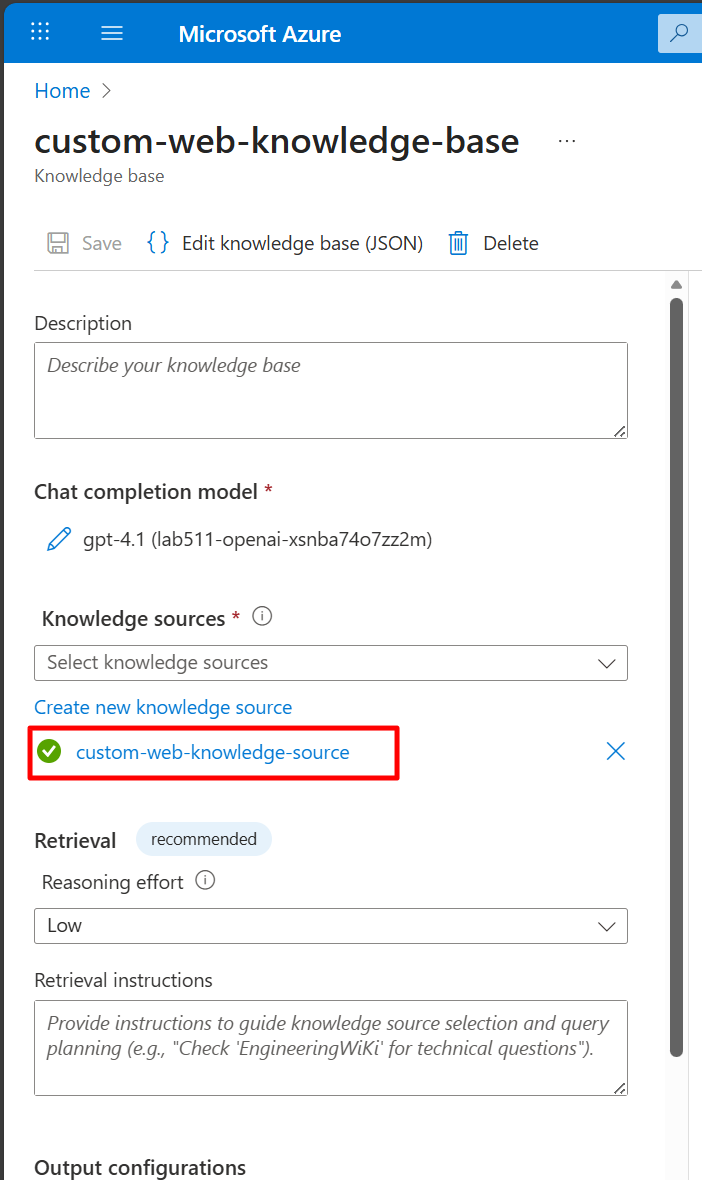

In [3]:
from azure.search.documents.indexes.models import AzureOpenAIVectorizerParameters, KnowledgeBase, KnowledgeBaseAzureOpenAIModel, KnowledgeRetrievalOutputMode, KnowledgeSourceReference

aoai_params = AzureOpenAIVectorizerParameters(
    resource_url=azure_openai_endpoint,
    deployment_name=azure_openai_chatgpt_deployment,
    model_name=azure_openai_chatgpt_model_name,
    api_key=azure_openai_key
)

knowledge_base = KnowledgeBase(
    name=knowledge_base_name,
    models=[KnowledgeBaseAzureOpenAIModel(azure_open_ai_parameters=aoai_params)],
    knowledge_sources=[
        KnowledgeSourceReference(name=ks.name)
    ],
    output_mode=KnowledgeRetrievalOutputMode.ANSWER_SYNTHESIS
)

index_client.create_or_update_knowledge_base(knowledge_base)
print(f"Knowledge base '{knowledge_base_name}' created or updated successfully.")

Knowledge base 'web-knowledge-base' created or updated successfully.


## 단계 4: 웹 콘텐츠 쿼리

이제 웹 지식이 필요한 질문을 할 수 있습니다. "How tall is the Eiffel tower?"라는 질문은 내부 HR이나 건강 문서에서는 알 수 없지만, 웹에서는 알 수 있습니다.

쿼리를 실행하면 지식 베이스가 공개 웹을 검색하고, 관련 콘텐츠를 검색하며, 사용된 웹 페이지를 가리키는 인용과 함께 답변을 합성합니다. 어떤 웹사이트가 참조되었는지 확인하려면 참조를 확인하세요.

In [4]:
from azure.search.documents.knowledgebases import KnowledgeBaseRetrievalClient
from azure.search.documents.knowledgebases.models import KnowledgeBaseMessage, KnowledgeBaseMessageTextContent, KnowledgeBaseRetrievalRequest, WebKnowledgeSourceParams
from IPython.display import display, Markdown

knowledge_base_client = KnowledgeBaseRetrievalClient(endpoint=endpoint, knowledge_base_name=knowledge_base_name, credential=credential)

web_ks_params = WebKnowledgeSourceParams(
    knowledge_source_name="web-knowledge-source",
    include_references=True,
    include_reference_source_data=True
)
req = KnowledgeBaseRetrievalRequest(
    messages=[
        KnowledgeBaseMessage(role="user", content=[KnowledgeBaseMessageTextContent(text="한국 마이크로소프트는 어디에 위치하고 있나요?")])
    ],
    knowledge_source_params=[
        web_ks_params
    ],
    include_activity=True
)

result = knowledge_base_client.retrieve(retrieval_request=req)
display(Markdown(result.response[0].content[0].text))

한국 마이크로소프트는 서울특별시 종로구 종로1길 50 더 케이트윈타워 A동 11층과 12층에 위치해 있습니다. 이곳은 경복궁과 광화문이 한눈에 내려다보이는 멋진 전망을 자랑하는 곳입니다[ref_id:0][ref_id:2][ref_id:3][ref_id:7].

## 단계 5: 응답, 참조, 활동 검토

아래 두 셀은 웹 쿼리에서 인용과 활동 로그를 보여줍니다.

**참조**는 질문에 답하기 위해 어떤 웹사이트가 사용되었는지 보여줍니다. 각 인용에는 URL과 답변에 기여한 특정 텍스트 스니펫이 포함됩니다.

**활동 로그**는 내부에서 무슨 일이 일어났는지 보여줍니다: 어떤 웹 검색이 수행되었는지, 어떤 URL이 검색되었는지, 결과가 어떻게 순위 지정되었는지.

In [5]:
import json

references = json.dumps([ref.as_dict() for ref in result.references], indent=2)
print(references)

[
  {
    "type": "web",
    "id": "0",
    "activity_source": 2,
    "source_data": {
      "url": "https://www.microsoft.com/ko-kr",
      "title": "Microsoft \u2013 AI, \ud074\ub77c\uc6b0\ub4dc, \uc0dd\uc0b0\uc131, \ucef4\ud4e8\ud305, \uac8c\uc784, \uc571"
    },
    "url": "https://www.microsoft.com/ko-kr",
    "title": "Microsoft \u2013 AI, \ud074\ub77c\uc6b0\ub4dc, \uc0dd\uc0b0\uc131, \ucef4\ud4e8\ud305, \uac8c\uc784, \uc571"
  },
  {
    "type": "web",
    "id": "2",
    "activity_source": 2,
    "source_data": {
      "url": "https://local.microsoft.com/ko/blog/contact-us-about-the-datacenter-in-korea/",
      "title": "\ud55c\uad6d \ub370\uc774\ud130\uc13c\ud130\uc5d0 \ub300\ud55c \ubb38\uc758 - Microsoft \ub85c\uceec"
    },
    "url": "https://local.microsoft.com/ko/blog/contact-us-about-the-datacenter-in-korea/",
    "title": "\ud55c\uad6d \ub370\uc774\ud130\uc13c\ud130\uc5d0 \ub300\ud55c \ubb38\uc758 - Microsoft \ub85c\uceec"
  },
  {
    "type": "web",
    "id": "1",
    

In [6]:
activity_content = json.dumps([a.as_dict() for a in result.activity], indent=2)
print(activity_content)

[
  {
    "id": 0,
    "type": "modelQueryPlanning",
    "elapsed_ms": 1219,
    "input_tokens": 1459,
    "output_tokens": 65
  },
  {
    "id": 1,
    "type": "web",
    "elapsed_ms": 643,
    "knowledge_source_name": "web-knowledge-source",
    "query_time": "2026-01-22T07:25:39.667Z",
    "count": 17,
    "web_arguments": {
      "search": "\ud55c\uad6d \ub9c8\uc774\ud06c\ub85c\uc18c\ud504\ud2b8 \ubcf8\uc0ac \uc704\uce58"
    }
  },
  {
    "id": 2,
    "type": "web",
    "elapsed_ms": 482,
    "knowledge_source_name": "web-knowledge-source",
    "query_time": "2026-01-22T07:25:40.550Z",
    "count": 18,
    "web_arguments": {
      "search": "\ud55c\uad6d \ub9c8\uc774\ud06c\ub85c\uc18c\ud504\ud2b8 \uc8fc\uc18c"
    }
  },
  {
    "id": 3,
    "type": "agenticReasoning",
    "reasoning_tokens": 15994,
    "retrieval_reasoning_effort": {
      "kind": "low"
    }
  },
  {
    "id": 4,
    "type": "modelAnswerSynthesis",
    "elapsed_ms": 1806,
    "input_tokens": 7358,
    "output_t

## 단계 6: 특정 도메인으로 제한

허용된 도메인을 지정하여 지식 베이스가 검색하는 웹사이트를 제어할 수 있습니다. 이는 산업 문서나 규제 웹사이트와 같이 특정 신뢰할 수 있는 외부 소스와 내부 데이터를 결합하려는 경우에 유용합니다.

아래 코드는 `britannica.com`으로 제한된 새 웹 지식 소스를 생성합니다. `include_subpages=True`를 설정하면 지식 베이스가 홈페이지뿐만 아니라 해당 도메인의 모든 페이지를 검색할 수 있습니다.

제한된 소스를 생성한 후, 이를 사용하는 새 지식 베이스를 생성합니다.

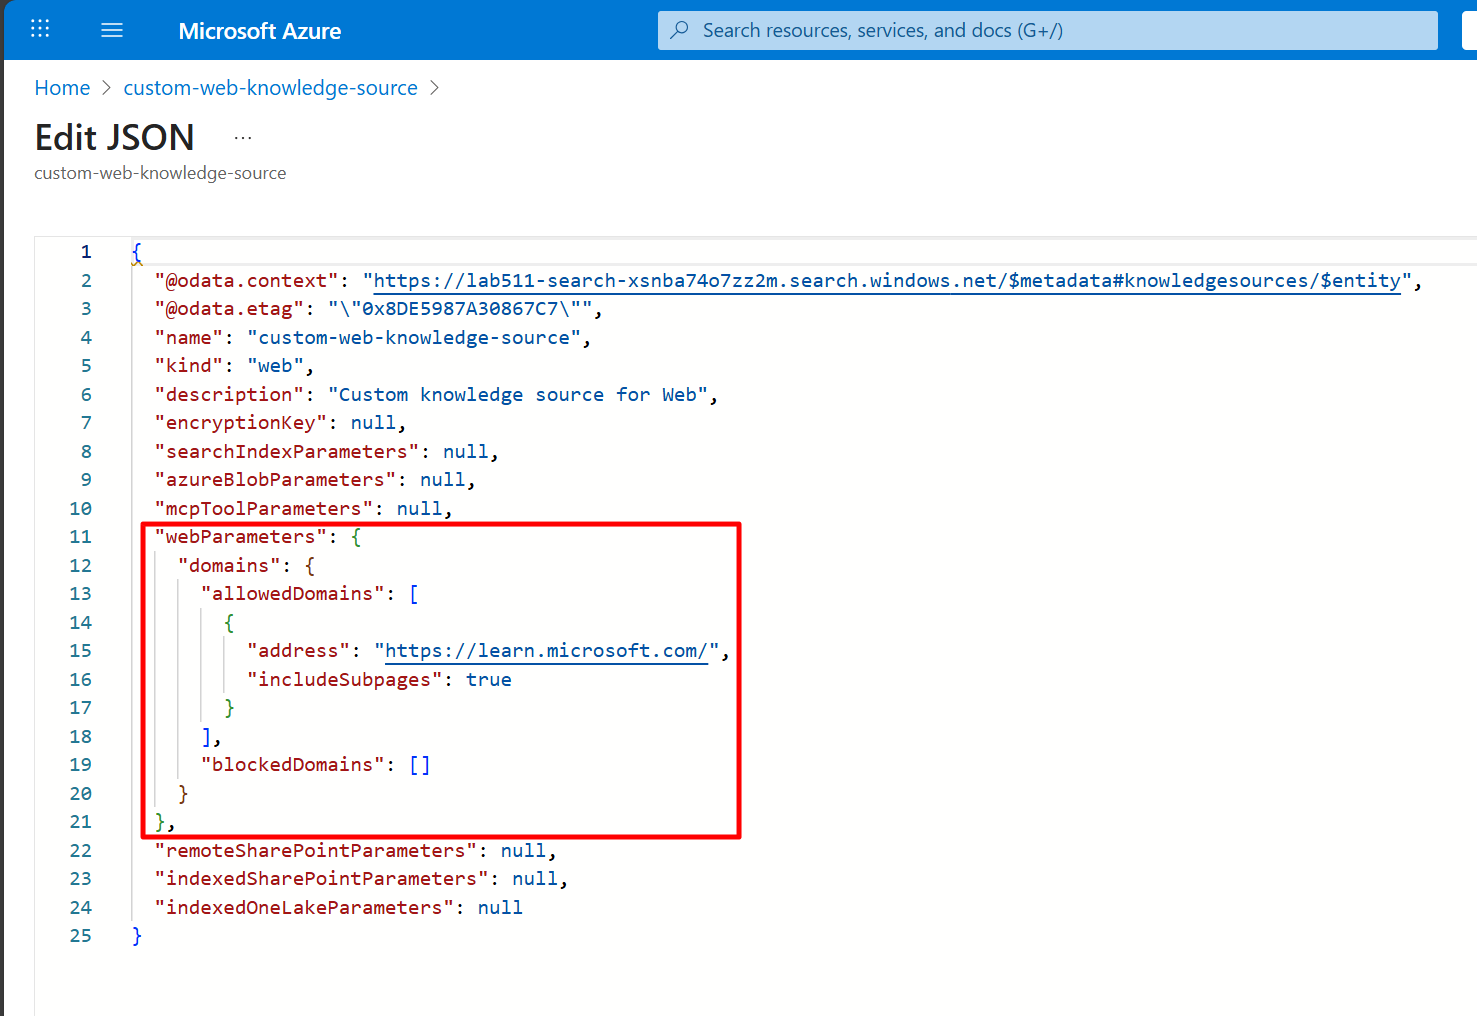

In [8]:
from azure.search.documents.indexes.models import WebKnowledgeSourceDomain, WebKnowledgeSourceDomains, WebKnowledgeSourceParameters

ks = WebKnowledgeSource(
    name="custom-web-knowledge-source",
    description="Custom knowledge source for Web",
    web_parameters = WebKnowledgeSourceParameters(
        domains = WebKnowledgeSourceDomains(
            allowed_domains=[
                WebKnowledgeSourceDomain(address="https://learn.microsoft.com/", include_subpages=True),
            ]
        )
    )
)
index_client.create_or_update_knowledge_source(knowledge_source=ks)
print(f"Knowledge source '{ks.name}' created or updated successfully.")

knowledge_base = KnowledgeBase(
    name="custom-web-knowledge-base",
    models=[KnowledgeBaseAzureOpenAIModel(azure_open_ai_parameters=aoai_params)],
    knowledge_sources=[
        KnowledgeSourceReference(name=ks.name)
    ],
    output_mode=KnowledgeRetrievalOutputMode.ANSWER_SYNTHESIS
)

index_client.create_or_update_knowledge_base(knowledge_base)
print(f"Knowledge base '{knowledge_base.name}' created or updated successfully.")

Knowledge source 'custom-web-knowledge-source' created or updated successfully.
Knowledge base 'custom-web-knowledge-base' created or updated successfully.


## 단계 7: 제한된 웹 소스 쿼리

이제 에펠탑에 대한 동일한 질문으로 제한된 지식 베이스를 쿼리합니다. 이번에는 지식 베이스가 답변을 위해 learn.microsoft.com 에서만 검색할 수 있습니다.

단계 4의 결과와 비교해보세요. 답변이 약간 다를 수 있음을 확인할 수 있습니다.

In [10]:
custom_knowledge_base_client = KnowledgeBaseRetrievalClient(endpoint=endpoint, knowledge_base_name=knowledge_base.name, credential=credential)

web_ks_params = WebKnowledgeSourceParams(
    knowledge_source_name=ks.name,
    include_references=True,
    include_reference_source_data=True
)
req = KnowledgeBaseRetrievalRequest(
    messages=[
        KnowledgeBaseMessage(role="user", content=[KnowledgeBaseMessageTextContent(text="한국 마이크로소프트는 어디에 위치하고 있나요?")])
    ],
    knowledge_source_params=[
        web_ks_params
    ],
    include_activity=True
)

result = custom_knowledge_base_client.retrieve(retrieval_request=req)
display(Markdown(result.response[0].content[0].text))

한국 마이크로소프트 본사의 정확한 위치에 대한 정보는 찾을 수 없었습니다. 다만, 마이크로소프트에서는 광화문 본사에서 일반인도 참여할 수 있는 세미나를 진행하기도 한다는 언급이 있습니다. 따라서 한국 마이크로소프트 본사는 광화문에 위치해 있을 가능성이 있습니다[ref_id:1].

## 단계 8: 제한된 소스 결과 검토

아래 두 셀은 도메인 제한 쿼리에서 인용과 활동 로그를 보여줍니다.

모든 인용이 britannica.com에서 오는지 참조를 확인하세요. 활동 로그는 지식 베이스가 허용된 도메인으로 웹 검색을 어떻게 제한했는지 보여줍니다.

In [11]:
references = json.dumps([ref.as_dict() for ref in result.references], indent=2)
print(references)

[
  {
    "type": "web",
    "id": "0",
    "activity_source": 2,
    "source_data": {
      "url": "https://learn.microsoft.com/ko-kr/answers/questions/5022169/question-5022169",
      "title": "\uace0\uac1d\uc13c\ud130 \ubb38\uc758\uc804\ud654 - Microsoft Q&A"
    },
    "url": "https://learn.microsoft.com/ko-kr/answers/questions/5022169/question-5022169",
    "title": "\uace0\uac1d\uc13c\ud130 \ubb38\uc758\uc804\ud654 - Microsoft Q&A"
  },
  {
    "type": "web",
    "id": "2",
    "activity_source": 2,
    "source_data": {
      "url": "https://learn.microsoft.com/ko-kr/answers/questions/5026907/question-5026907",
      "title": "\uace0\uac1d\uc13c\ud130 \uc804\ud654\ubc88\ud638 - Microsoft Q&A"
    },
    "url": "https://learn.microsoft.com/ko-kr/answers/questions/5026907/question-5026907",
    "title": "\uace0\uac1d\uc13c\ud130 \uc804\ud654\ubc88\ud638 - Microsoft Q&A"
  },
  {
    "type": "web",
    "id": "4",
    "activity_source": 2,
    "source_data": {
      "url": "https://l

In [12]:
import pandas as pd

activity_types = [{"type": a.type} for a in result.activity]

df = pd.DataFrame(activity_types)

print("Activity Log Steps")
df

Activity Log Steps


,type
0,modelQueryPlanning
1,web
2,web
3,agenticReasoning
4,modelAnswerSynthesis


In [13]:
activity_content = json.dumps([a.as_dict() for a in result.activity], indent=2)
print("Activity Details")
print(activity_content)

Activity Details
[
  {
    "id": 0,
    "type": "modelQueryPlanning",
    "elapsed_ms": 1051,
    "input_tokens": 1459,
    "output_tokens": 65
  },
  {
    "id": 1,
    "type": "web",
    "elapsed_ms": 522,
    "knowledge_source_name": "custom-web-knowledge-source",
    "query_time": "2026-01-22T07:27:54.483Z",
    "count": 5,
    "web_arguments": {
      "search": "\ud55c\uad6d \ub9c8\uc774\ud06c\ub85c\uc18c\ud504\ud2b8 \ubcf8\uc0ac \uc704\uce58"
    }
  },
  {
    "id": 2,
    "type": "web",
    "elapsed_ms": 425,
    "knowledge_source_name": "custom-web-knowledge-source",
    "query_time": "2026-01-22T07:27:55.102Z",
    "count": 10,
    "web_arguments": {
      "search": "\ud55c\uad6d \ub9c8\uc774\ud06c\ub85c\uc18c\ud504\ud2b8 \uc8fc\uc18c"
    }
  },
  {
    "id": 3,
    "type": "agenticReasoning",
    "reasoning_tokens": 19950,
    "retrieval_reasoning_effort": {
      "kind": "low"
    }
  },
  {
    "id": 4,
    "type": "modelAnswerSynthesis",
    "elapsed_ms": 1720,
    "inpu

## 요약

이제 `WebKnowledgeSource`를 사용하여 지식 베이스에 웹 콘텐츠를 추가했습니다. 이를 통해 내부 데이터와 웹의 공개 정보를 결합할 수 있습니다.

**기억해야 할 핵심 개념:**
- `WebKnowledgeSource`는 공개 웹 URL을 실시간으로 쿼리합니다
- 전체 웹을 검색하거나 특정 도메인으로 제한할 수 있습니다
- `include_subpages=True`는 도메인 내 모든 페이지 검색을 허용합니다
- 웹 인용에는 내부 파일 경로 대신 URL이 포함됩니다

### 다음 단계

➡️ [파트 5: Blob 지식 소스](part5-blob-knowledge-source.ipynb)로 계속하여 Azure Blob Storage에서 문서를 업로드하고 최소 vs. 표준 인덱싱을 비교하는 방법을 배웁니다.